# HIDS 7006 - AI for Health Applications - Final Project
Fadwa Elfeituri (NetID: ffe7)

---

# Kaggle Model - Binary Classification of Oral Cancer Detection (Cancer vs Non-Cancer)

# Step 2 - Model Development

This notebook documents the model development phase for a binary classification task to detect oral cancer using clinical photographs from the merged Kaggle_1 and Kaggle_2 datasets. The primary objective is to build an effective deep learning model capable of distinguishing between cancerous and non-cancerous images.

To validate the added value of structured metadata features, two model architectures are compared:
1. **Two-Branch Model:** Combines image features with engineered metadata (e.g., file size, aspect ratio, color mode) in a dual-input neural network.
2. **Image-Only Model:** A baseline CNN trained using only image inputs.

## Key Steps Included in This Notebook:
1. **Prepare Input Pipelines**
      * Loaded the cleaned image dataset and enriched metadata from the previous preprocessing notebook.
      * Defined TensorFlow data pipelines to feed both image tensors and metadata features into the model.
2. **Develop a Two-Branch Deep Learning Model**
      * Constructed a dual-input architecture:
        * Image branch: CNN layers extract spatial features from resized RGB images.
        * Metadata branch: Dense layers learn patterns from engineered features like file size, aspect ratio, and encoding type.
      * Merged both branches and trained the model using binary crossentropy and accuracy metrics.
3. **Hyperparameter Tuning**
      * Ran multiple training configurations to explore different dropout rates and L2 regularization strengths.
      * Identified the best-performing setting based on validation accuracy (run_B).
4. **Compare with an Image-Only Baseline**
      * Trained a second model using only the image input branch (no metadata).
      * Compared both models using test accuracy, confusion matrices, classification reports, and prediction visualizations.
      * This comparison confirmed that including metadata consistently improved performance.
5. **Model Evaluation and Saving**
      * Evaluated test accuracy on a held-out set.
      * Visualized prediction errors and training history.
      * Saved the best-performing model to disk for future inference or deployment.

The goal is to quantify the added diagnostic value of structured metadata when classifying clinical images for early oral cancer detection.

## Dependencies & Notes:
* Requires the cleaned and resized image dataset located in the KaggleAll_clean folder.
* Uses the enriched CSV manifest created in the companion notebook: KaggleModel_DataCleaning_notebook.ipynb.

#  Section 1: Building Two-Branch Model — Image + Metadata Classification

In [ ]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. **Prepare Input Pipelines**
      * Loaded the cleaned image dataset and enriched metadata from the previous preprocessing notebook.
      * Defined TensorFlow data pipelines to feed both image tensors and metadata features into the model.

In [ ]:
# Umport Libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import shutil
import re
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from pathlib import Path
from collections import Counter
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input, Model, layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
tf.config.run_functions_eagerly(True)

In [ ]:
# Load Preprocessed Manifest
df = pd.read_csv(
    '/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/'
    'Project/Datasets/Processed/Clinical_Images/manifest+features_kaggleAll.csv'
)

In [ ]:
# Preview Manifest
df.head()

,filepath,label,label_idx,orig_width,orig_height,clean_width,clean_height,filesize_bytes,filesize_kb,clean_ar,orig_ar,scale_factor,orig_mode_RGB,orig_mode_RGBA,orig_format_PNG,orig_format_WEBP
0,/content/drive/MyDrive/Georgetown University/H...,CANCER,1,-0.419129,-0.392174,0.0,0.0,3411,-0.515790,0.0,-0.354828,-0.272748,1,0,0,0
1,/content/drive/MyDrive/Georgetown University/H...,CANCER,1,-0.052488,-0.439926,0.0,0.0,3006,-1.239360,0.0,2.166078,-0.410498,1,0,0,0
2,/content/drive/MyDrive/Georgetown University/H...,CANCER,1,-0.665827,-0.630932,0.0,0.0,3160,-0.964225,0.0,-0.400151,0.619567,1,0,0,0
3,/content/drive/MyDrive/Georgetown University/H...,CANCER,1,-0.579960,-0.677319,0.0,0.0,3165,-0.955292,0.0,1.134342,0.516266,1,0,0,0
4,/content/drive/MyDrive/Georgetown University/H...,CANCER,1,-0.599041,-0.686870,0.0,0.0,4114,0.740183,0.0,1.077770,0.624942,1,0,0,0


In [ ]:
# Extract the image filename from each filepath to support unique splits and linking

# Add filename column
df['filename'] = df['filepath'].apply(lambda p: Path(p).name)

# Drop duplicate filenames before splitting
df_unique = df.drop_duplicates(subset='filename', keep='first')

# Stratified split on unique filenames
train_fnames, temp_fnames = train_test_split(
    df_unique[['filename', 'label_idx']],
    test_size=0.3,
    stratify=df_unique['label_idx'],
    random_state=42
)

val_fnames, test_fnames = train_test_split(
    temp_fnames,
    test_size=2/3,
    stratify=temp_fnames['label_idx'],
    random_state=42
)

# Reconstruct full splits using the original df (with metadata)
train_df = df[df['filename'].isin(train_fnames['filename'])]
val_df   = df[df['filename'].isin(val_fnames['filename'])]
test_df  = df[df['filename'].isin(test_fnames['filename'])]

# Double-check no overlap
train_paths = set(train_df['filename'])
val_paths   = set(val_df['filename'])
test_paths  = set(test_df['filename'])

print("Train ∩ Test:", len(train_paths & test_paths))
print("Train ∩ Val :", len(train_paths & val_paths))
print("Val ∩ Test :", len(val_paths & test_paths))

Train ∩ Test: 0
Train ∩ Val : 0
Val ∩ Test : 0


In [ ]:
# Build tf.data pipelines
metadata_cols = [
  'filesize_kb','clean_ar','orig_ar','scale_factor',
  'orig_mode_RGB','orig_mode_RGBA',
  'orig_format_PNG','orig_format_WEBP'
]
TARGET_SIZE = (128, 128)

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, TARGET_SIZE)
    return img / 255.0

def parse_row(fp, meta, lbl):
    return (load_and_preprocess_image(fp), meta), lbl

def make_ds(df, batch=32, shuffle=True):
    paths = df['filepath'].values
    metas = df[metadata_cols].values.astype('float32')
    lbls  = df['label_idx'].values.astype('float32')
    ds = tf.data.Dataset.from_tensor_slices((paths, metas, lbls))
    ds = ds.map(parse_row, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(len(df))
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_df, shuffle=True)
val_ds   = make_ds(val_df,   shuffle=False)
test_ds  = make_ds(test_df,  shuffle=False)

In [ ]:
# Create a Tuning Table to Track Results
tuning_log = pd.DataFrame(columns=[
    'run_name', 'dropout', 'l2', 'dense_units', 'train_acc', 'val_acc', 'test_acc'
])

In [ ]:
# Define Two-Branch Model Function
def build_model(dropout=0.3, l2_val=0.0005, dense_units=128):
    img_in = Input((128, 128, 3), name='img_in')
    meta_in = Input((len(metadata_cols),), name='meta_in')

    # Image branch
    x = layers.Conv2D(32, 3, activation='relu', kernel_regularizer=l2(l2_val))(img_in)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', kernel_regularizer=l2(l2_val))(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', kernel_regularizer=l2(l2_val))(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_val))(x)
    x = layers.Dropout(dropout)(x)
    img_branch = Model(img_in, x)

    # Metadata branch
    y = layers.Dense(64, activation='relu', kernel_regularizer=l2(l2_val))(meta_in)
    y = layers.Dense(32, activation='relu', kernel_regularizer=l2(l2_val))(y)
    meta_branch = Model(meta_in, y)

    # Combine branches
    combined = layers.concatenate([img_branch.output, meta_branch.output])
    z = layers.Dense(64, activation='relu', kernel_regularizer=l2(l2_val))(combined)
    z = layers.Dropout(dropout)(z)
    out = layers.Dense(1, activation='sigmoid')(z)

    model = Model([img_branch.input, meta_branch.input], out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Specify Tuning Configurations
configs = [
    {'run_name': 'run_A', 'dropout': 0.3, 'l2': 0.0005, 'dense': 128},
    {'run_name': 'run_B', 'dropout': 0.4, 'l2': 0.0001, 'dense': 128},
    {'run_name': 'run_C', 'dropout': 0.5, 'l2': 0.0005, 'dense': 128},
]

for config in configs:
    print(f"🔧 Training {config['run_name']}...")

    # Build model with current config
    model = build_model(
        dropout=config['dropout'],
        l2_val=config['l2'],
        dense_units=config['dense']
    )

    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=15,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
        verbose=0
    )

    # Evaluate
    _, test_acc = model.evaluate(test_ds, verbose=0)

    # Log
    tuning_log.loc[len(tuning_log)] = {
        'run_name': config['run_name'],
        'dropout': config['dropout'],
        'l2': config['l2'],
        'dense_units': config['dense'],
        'train_acc': history.history['accuracy'][-1],
        'val_acc': history.history['val_accuracy'][-1],
        'test_acc': test_acc
    }

    print(f"✅ {config['run_name']} test_acc: {test_acc:.4f}")

🔧 Training run_A...
✅ run_A test_acc: 0.8197
🔧 Training run_B...
✅ run_B test_acc: 0.9208
🔧 Training run_C...
✅ run_C test_acc: 0.8552


In [ ]:
# Load Best Performing Model
kaggle_model = keras.models.load_model('/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Model/kaggleAll_best_model_run_B.h5')

In [ ]:
# Model Architecture Summary
kaggle_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_in (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 126, 126,  │        896 │ img_in[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 63, 63,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 30, 30,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 28, 28,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 14, 14,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 25088)     │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_in             │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │  3,211,392 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │        576 │ meta_in[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 32)        │      2,080 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 160)       │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │     10,304 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         65 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,317,667 (12.66 MB)

 Trainable params: 3,317,665 (12.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
# Model Training with Checkpointing and Early Stopping

# 1. Epoch setting
EPOCHS = 15

# 2. Checkpoint directory and filename
CP_DIR = Path('/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Model/checkpoints')
CP_DIR.mkdir(parents=True, exist_ok=True)
cp_path = str(CP_DIR/'cp_{epoch:02d}.weights.h5')

# 3. ModelCheckpoint callback
cp_cb = ModelCheckpoint(
    filepath=cp_path,
    monitor='val_loss',
    save_best_only=True,     # keep best model only
    save_weights_only=True,
    verbose=1,
    save_freq='epoch'
)

# 3.5 Re-compile loaded model
kaggle_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 4. Fit the model
history = kaggle_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[
      EarlyStopping(monitor='val_loss', patience=3),
      cp_cb
    ]
)


Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9453 - loss: 0.2760
Epoch 1: val_loss improved from inf to 0.23021, saving model to /content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Model/checkpoints/cp_01.weights.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 302ms/step - accuracy: 0.9452 - loss: 0.2758 - val_accuracy: 0.9607 - val_loss: 0.2302
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9341 - loss: 0.2783
Epoch 2: val_loss improved from 0.23021 to 0.21069, saving model to /content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Model/checkpoints/cp_02.weights.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - accuracy: 0.9344 - loss: 0.2777 - val_accuracy: 0.9607 - val_loss: 0.2107
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9719 - loss: 0.2155
Epoch 3: val_loss did not improve from 0.21069
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.9718 - loss: 0.2157 - val_accuracy: 0.9494 - 

In [ ]:
# Load best weights
kaggle_model.load_weights('/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Model/checkpoints/cp_02.weights.h5')

In [ ]:
# Evaluate Final Model on Test Set
test_loss, test_acc = kaggle_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9813 - loss: 0.2002
Test Accuracy: 0.9672
Test Loss: 0.2214


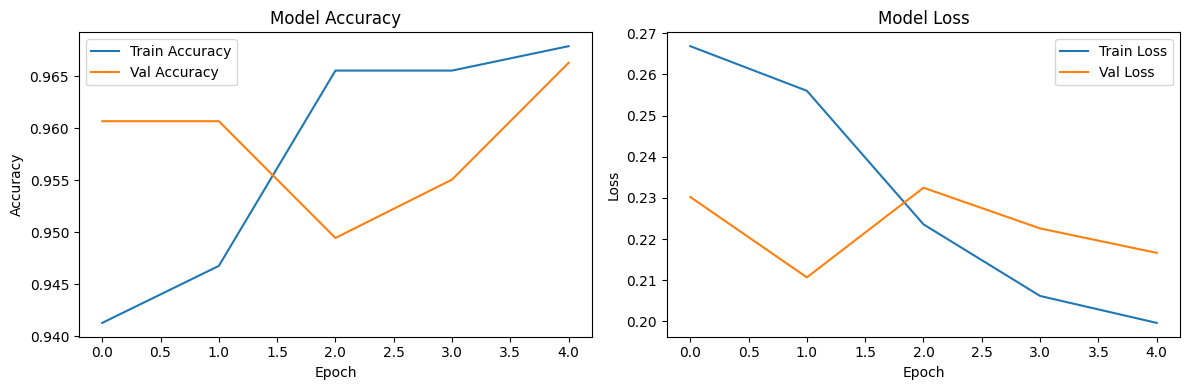

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to visualize
plot_history(history)

In [ ]:
# Predict class probabilities on test set
preds = kaggle_model.predict(test_ds)

# Convert to class labels (0 = Non-Cancer, 1 = Cancer)
predicted_labels = (preds > 0.5).astype(int).flatten()

# Get true labels from test DataFrame
true_labels = test_df['label_idx'].values[:len(predicted_labels)]


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


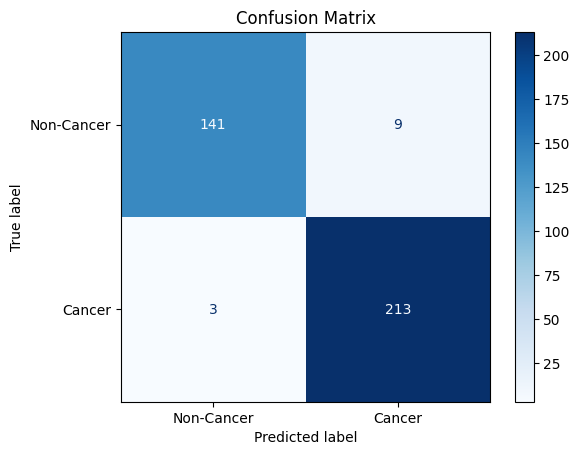

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancer', 'Cancer'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [ ]:
# Classification Report
y_true = []
y_pred = []

for (img_batch, meta_batch), label_batch in test_ds:
    preds = kaggle_model.predict([img_batch, meta_batch])
    y_true.extend(label_batch.numpy())
    y_pred.extend((preds.flatten() > 0.5).astype(int))
report = classification_report(y_true, y_pred, target_names=['Non-Cancer', 'Cancer'])
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
              precision    recall  f1-score   support

  Non-Cancer       0.98      0.94      0.96       150
      Cancer       0.96      0.99      0.97       216

    accuracy                           0.97       366
   macro avg       0.97      0.96      0.97       366
weighted avg       0.97      0.97      0.97       366



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


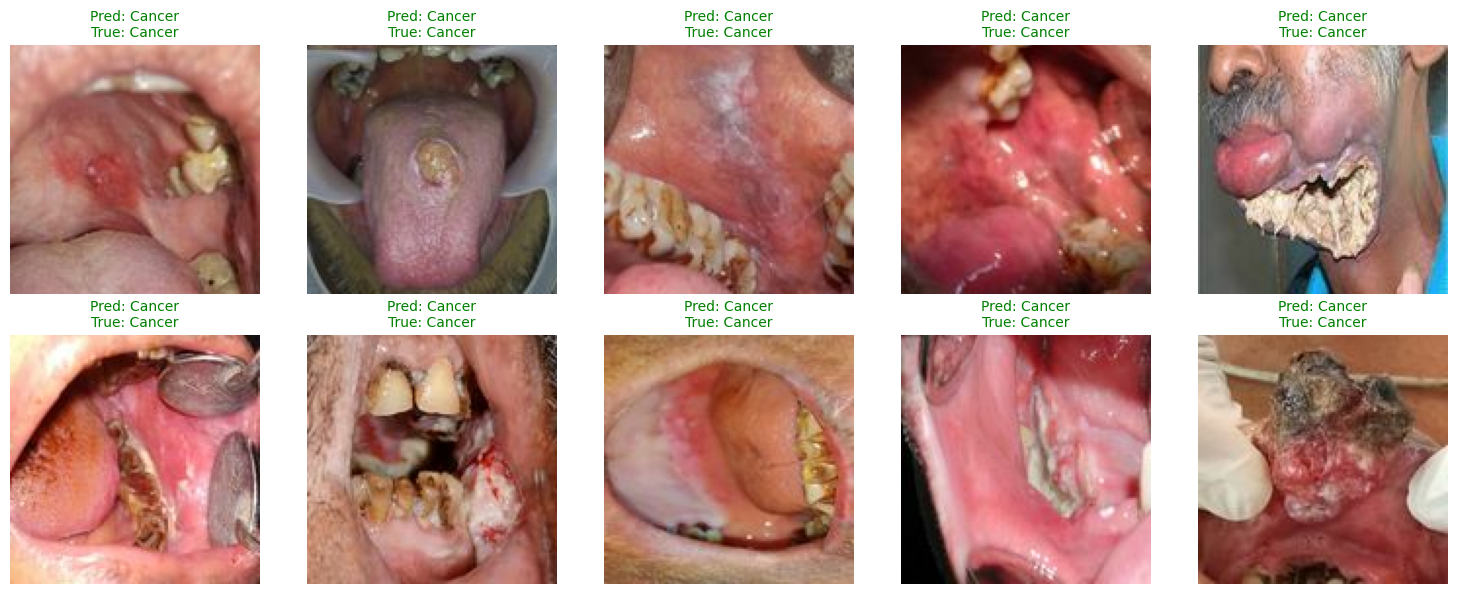

In [ ]:
# Visualize Random Test Predictions

# Shuffle the test dataset (for random visualization only)
shuffled_test_ds = test_ds.shuffle(1000, reshuffle_each_iteration=True)

# Take one random batch
for (img_batch, meta_batch), label_batch in shuffled_test_ds.take(1):
    preds = kaggle_model.predict([img_batch, meta_batch])
    preds_cls = (preds > 0.5).astype(int).flatten()
    true_cls = label_batch.numpy().astype(int)

    # Shuffle batch order
    idxs = np.random.permutation(len(img_batch))
    img_batch = img_batch.numpy()[idxs]
    preds_cls = preds_cls[idxs]
    true_cls = true_cls[idxs]

    # Plot 10 samples
    plt.figure(figsize=(15, 6))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(img_batch[i])
        pred_label = 'Cancer' if preds_cls[i] == 1 else 'Non-Cancer'
        true_label = 'Cancer' if true_cls[i] == 1 else 'Non-Cancer'
        color = 'green' if preds_cls[i] == true_cls[i] else 'red'
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", color=color, fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

In [ ]:
# Save Final Best Model
kaggle_model.save('/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Model/kaggleAll_final_best_model.keras')

In [ ]:
# Save Results of Two-Branch Model
history_meta = history                    # preserve training history
two_branch_test_acc = test_acc            # save test accuracy from evaluate()

# Section 2: Building and Comparing an Image-Only Model

In [ ]:
# Prepare Image-Only Datasets
def make_ds_img(df, batch=32, shuffle=True):
    paths = df['filepath'].values
    lbls  = df['label_idx'].values.astype('float32')
    ds = tf.data.Dataset.from_tensor_slices((paths, lbls))
    ds = ds.map(
        lambda p, l: (load_and_preprocess_image(p), l),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

train_ds_img = make_ds_img(train_df, batch=32, shuffle=True)
val_ds_img   = make_ds_img(val_df,   batch=32, shuffle=False)
test_ds_img  = make_ds_img(test_df,  batch=32, shuffle=False)

In [ ]:
# Define image-only model matching two-branch image settings
img_in_only = Input((*TARGET_SIZE, 3), name='img_in_only')

x = layers.Conv2D(32, 3, activation='relu', kernel_regularizer=l2(0.0005))(img_in_only)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = layers.Dropout(0.3)(x)
out_only = layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0005))(x)

# Build and compile model
model_img = Model(img_in_only, out_only, name='img_only_cnn')
model_img.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_img.summary()

Model: "img_only_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img_in_only (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the image-only model
EPOCHS = 15

# Early stopping: stop if val_loss doesn't improve for 3 epochs
es_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history_img = model_img.fit(
    train_ds_img,
    validation_data=val_ds_img,
    epochs=EPOCHS,
    callbacks=[es_cb],
    verbose=1
)

# Evaluate on the test set
loss_img, img_only_test = model_img.evaluate(test_ds_img)

# Compare with the two-branch model
print(f"📊 Two-branch test accuracy = {two_branch_test_acc:.3f}")
print(f"🖼️ Image-only  test accuracy = {img_only_test:.3f}")

Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.5525 - loss: 0.8684 - val_accuracy: 0.6067 - val_loss: 0.7155
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.6541 - loss: 0.6883 - val_accuracy: 0.7640 - val_loss: 0.6105
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.7367 - loss: 0.5860 - val_accuracy: 0.7697 - val_loss: 0.5608
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.7736 - loss: 0.5378 - val_accuracy: 0.8202 - val_loss: 0.4979
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.8032 - loss: 0.4963 - val_accuracy: 0.7865 - val_loss: 0.5482
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.8056 - loss: 0.4823 - val_accuracy: 0.8483 - val_loss: 0.4742
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.8430 - loss: 0.4160 - val_accuracy: 0.8539 - val_loss: 0.4855
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.8419 - loss: 0.4085 - val_accuracy: 0

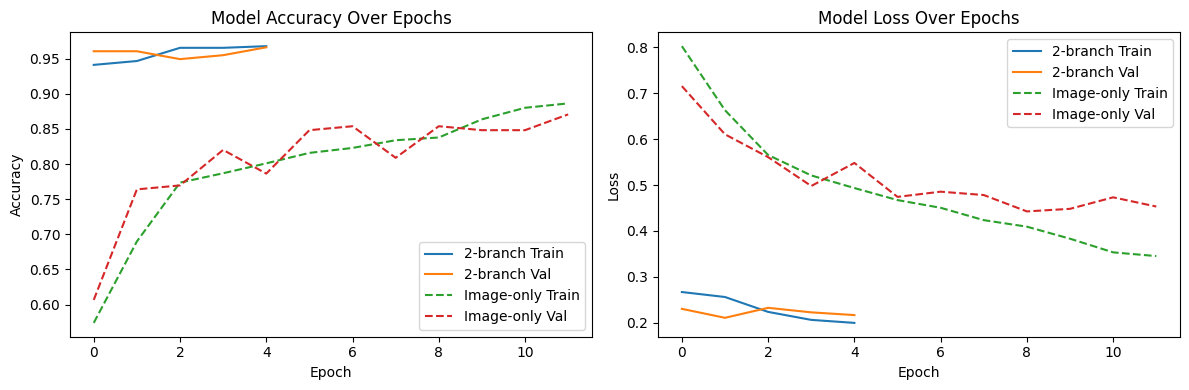

In [ ]:
# Compare Training Performance (Two-Branch vs Image-Only)
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history_meta.history['accuracy'], label='2-branch Train')
plt.plot(history_meta.history['val_accuracy'], label='2-branch Val')
plt.plot(history_img.history['accuracy'], '--', label='Image-only Train')
plt.plot(history_img.history['val_accuracy'], '--', label='Image-only Val')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history_meta.history['loss'], label='2-branch Train')
plt.plot(history_meta.history['val_loss'], label='2-branch Val')
plt.plot(history_img.history['loss'], '--', label='Image-only Train')
plt.plot(history_img.history['val_loss'], '--', label='Image-only Val')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


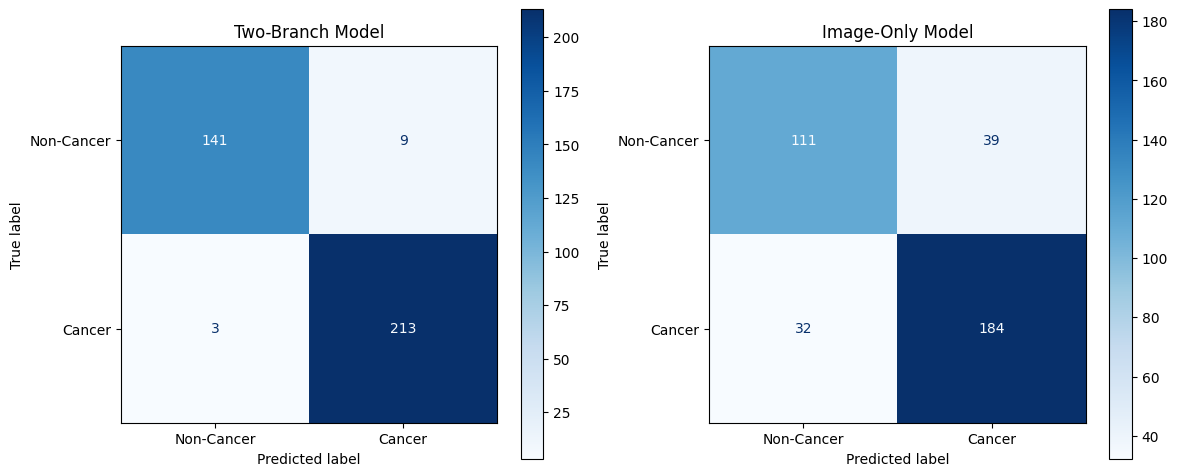

In [ ]:
# Step 1: Get predictions for the image-only model
y_true_img = []
y_pred_img = []

for img_batch, label_batch in test_ds_img:
    preds = model_img.predict(img_batch)
    y_true_img.extend(label_batch.numpy())
    y_pred_img.extend((preds.flatten() > 0.5).astype(int))

# Step 2: Confusion matrices
cm_meta = confusion_matrix(y_true, y_pred)  # from earlier (two-branch)
cm_img  = confusion_matrix(y_true_img, y_pred_img)

# Step 3: Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

disp_meta = ConfusionMatrixDisplay(confusion_matrix=cm_meta, display_labels=['Non-Cancer', 'Cancer'])
disp_img  = ConfusionMatrixDisplay(confusion_matrix=cm_img,  display_labels=['Non-Cancer', 'Cancer'])

disp_meta.plot(ax=axs[0], cmap=plt.cm.Blues, values_format='d')
axs[0].set_title("Two-Branch Model")

disp_img.plot(ax=axs[1], cmap=plt.cm.Blues, values_format='d')
axs[1].set_title("Image-Only Model")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<ipython-input-42-5624e5197700>:37: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-42-5624e5197700>:37: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


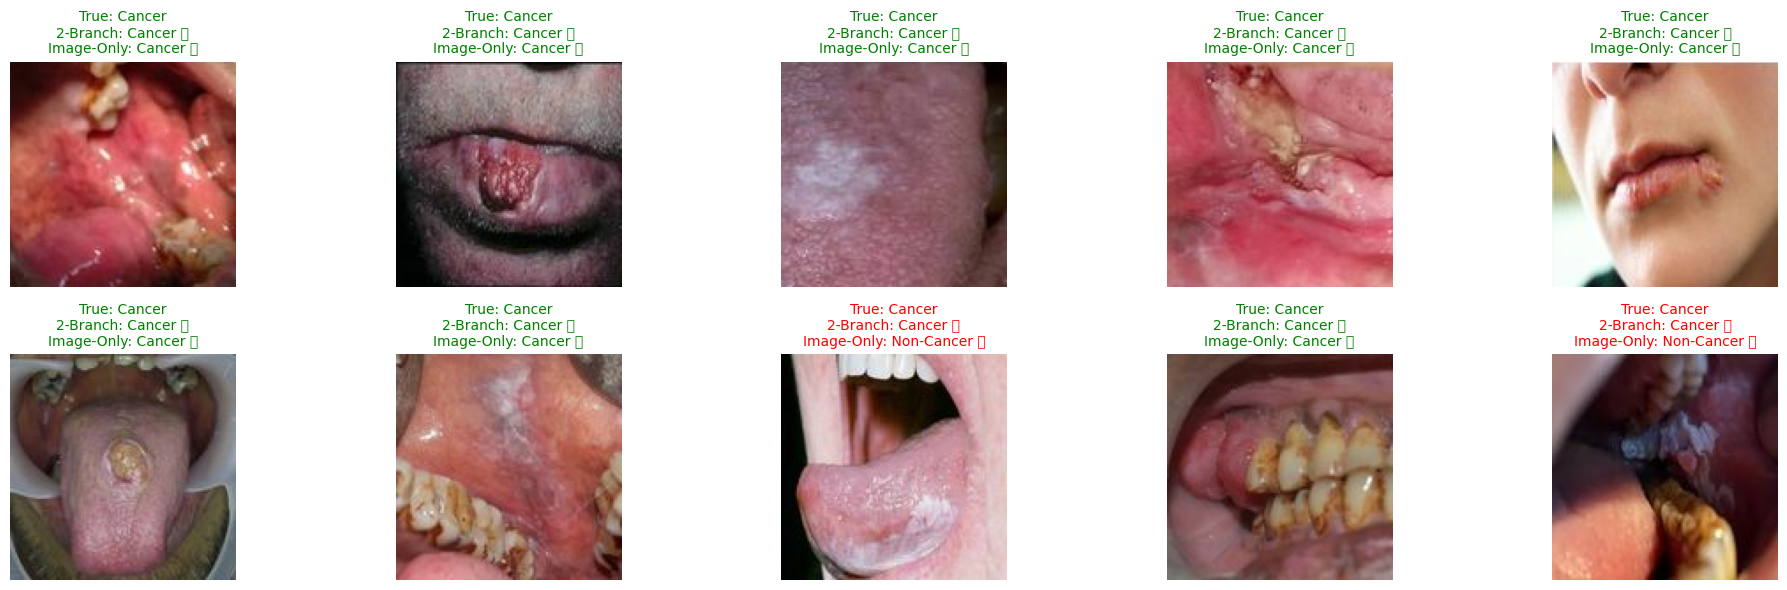

In [ ]:
# Step 1: Get one batch from the test set
for (img_batch, meta_batch), label_batch in test_ds.take(1):
    # Predictions from two-branch model
    preds_meta = kaggle_model.predict([img_batch, meta_batch])
    preds_meta_cls = (preds_meta.flatten() > 0.5).astype(int)

    # Predictions from image-only model
    preds_img = model_img.predict(img_batch)
    preds_img_cls = (preds_img.flatten() > 0.5).astype(int)

    true_cls = label_batch.numpy().astype(int)

    # Shuffle
    idxs = np.random.permutation(len(img_batch))
    img_batch = img_batch.numpy()[idxs]
    preds_meta_cls = preds_meta_cls[idxs]
    preds_img_cls = preds_img_cls[idxs]
    true_cls = true_cls[idxs]

    # Step 2: Plot 10 examples
    plt.figure(figsize=(20, 6))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(img_batch[i])
        meta_label = 'Cancer' if preds_meta_cls[i] == 1 else 'Non-Cancer'
        img_label = 'Cancer' if preds_img_cls[i] == 1 else 'Non-Cancer'
        true_label = 'Cancer' if true_cls[i] == 1 else 'Non-Cancer'
        match_meta = preds_meta_cls[i] == true_cls[i]
        match_img = preds_img_cls[i] == true_cls[i]

        ax.set_title(
            f"True: {true_label}\n2-Branch: {meta_label} {'✅' if match_meta else '❌'}\nImage-Only: {img_label} {'✅' if match_img else '❌'}",
            color='green' if match_meta and match_img else 'red',
            fontsize=10
        )
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

In [ ]:
# 📌 Two-Branch model (already predicted earlier)
report_meta = classification_report(y_true, y_pred, target_names=['Non-Cancer', 'Cancer'])
print("📊 Two-Branch Model Classification Report:\n")
print(report_meta)

# 📌 Image-Only model
report_img = classification_report(y_true_img, y_pred_img, target_names=['Non-Cancer', 'Cancer'])
print("\n🖼️ Image-Only Model Classification Report:\n")
print(report_img)

📊 Two-Branch Model Classification Report:

              precision    recall  f1-score   support

  Non-Cancer       0.98      0.94      0.96       150
      Cancer       0.96      0.99      0.97       216

    accuracy                           0.97       366
   macro avg       0.97      0.96      0.97       366
weighted avg       0.97      0.97      0.97       366


🖼️ Image-Only Model Classification Report:

              precision    recall  f1-score   support

  Non-Cancer       0.78      0.74      0.76       150
      Cancer       0.83      0.85      0.84       216

    accuracy                           0.81       366
   macro avg       0.80      0.80      0.80       366
weighted avg       0.81      0.81      0.81       366



In [ ]:
# Final Results Summary – Two-Branch vs Image-Only

# Gather best validation accuracy
best_val_meta = max(history_meta.history['val_accuracy'])
best_val_img  = max(history_img.history['val_accuracy'])

# Build comparison DataFrame
results = pd.DataFrame({
    'Model':        ['Two-Branch', 'Image-Only'],
    'Best Val Accuracy': [best_val_meta, best_val_img],
    'Test Accuracy':     [two_branch_test_acc, img_only_test]
})

# Display the results
print("📊 Final Performance Summary:\n")
print(results)

📊 Final Performance Summary:

        Model  Best Val Accuracy  Test Accuracy
0  Two-Branch           0.966292       0.967213
1  Image-Only           0.870786       0.806011
